# FFF Step 2: Scaffold selection

## Pre-requisites

- [ ] BulkDock & HIPPO set up for Target
- [ ] Algorithmic merges generated and placed
- [ ] Merges uploaded to Fragalysis and curated

In [5]:
%load_ext autoreload
%autoreload 2
import hippo
from os import environ, system
from pathlib import Path
import pandas as pd
import json
from mrich import print
import mrich
import shutil
import molparse as mp

In [17]:
target_name = "D68EV3C"

In [18]:
animal = hippo.HIPPO(target_name, Path(environ["BULK"])/"TARGETS"/target_name/f"{target_name}.sqlite")

 Creating HIPPO animal

name = D68EV3C

db_path = /opt/xchem-fragalysis-2/maxwin/BulkDock/TARGETS/D68EV3C/D68EV3C.sqlite

DEBUG: hippo.Database.__init__()

DEBUG: Database.path = /opt/xchem-fragalysis-2/maxwin/BulkDock/TARGETS/D68EV3C/D68EV3C.sqlite

DEBUG: hippo.Database.connect()

DEBUG: sqlite3.version='2.6.0'

 Success  Database connected @ /opt/xchem-fragalysis-2/maxwin/BulkDock/TARGETS/D68EV3C/D68EV3C.sqlite!

 Success  Initialised animal HIPPO("D68EV3C")!

## Add Manual designs

In [81]:
manual_designs = [
    # populate tuples in this format:
    # (smiles, alias, inspirations),
    ("CCS(=O)(=Nc1ccn2cnnc2c1)NCc1ccc2c(c1)OCO2", "v25-MW-mod",['7gp9-a', 'B0738a']),
    ("NC(=O)C1CCCN1COc1ccc2[nH]c(Sc3cccc4nncn34)nc2c1", "v34-MW-mod",['7gpf-a', 'B1219a']),
]

C7272 "v25-MW-mod"

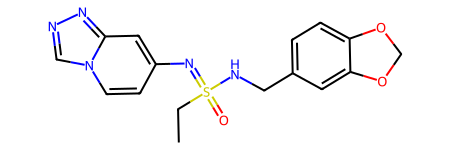

C7273 "v34-MW-mod"

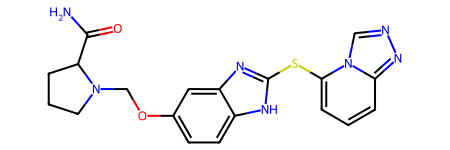

,smiles,hit1,hit2
0,CCS(=O)(=Nc1ccn2cnnc2c1)NCc1ccc2c(c1)OCO2,7gp9-a,B0738a
1,NC(=O)C1CCCN1COc1ccc2[nH]c(Sc3cccc4nncn34)nc2c1,7gpf-a,B1219a


In [98]:
data = []
for smiles, alias, inspirations in manual_designs:
    c = animal.register_compound(smiles=smiles, alias=alias)
    print(c)
    c.add_tag("manual design")
    c.draw()
    d = dict(smiles=c.smiles)
    for i,inspiration in enumerate(inspirations):
        pose = animal.poses[inspiration]
        assert pose
        d[f"hit{i+1}"] = pose.name
    data.append(d)

df = pd.DataFrame(data)
df.to_csv("iter1_manuals.csv", index=False)
df

In [97]:
animal.compounds["v25-MW-mod"].poses.draw()
animal.compounds["v34-MW-mod"].poses.draw()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Parse Curation CSVs

Instruct Fragalysis reviewers to label all their 'picks' as a certain colour. Then populate the dictionary below

In [48]:
csvs = {
    # populate the dictionary:
    # file : (author, selection_colour),
    "../curation/rl_iter1.csv" : ("RL", "green"),
    "../curation/wt_iter1.csv" : ("WT", "blue"),
    "../curation/df_iter1_35.csv" : ("DF", "green"),
    "../curation/df_iter1_36.csv" : ("DF", "green"),
    "../curation/df_iter1_37.csv" : ("DF", "green"),
    "../curation/df_iter1_37.csv" : ("DF", "green"),
    "../curation/mw_iter1_fstein.csv" : ("MW", "green"),
    "../curation/mw_iter1_knit_pure.csv" : ("MW", "green"),
    "../curation/mw_iter1_knit_impure.csv" : ("MW", "green"),
}

In [66]:
yes_tags = set()
for csv, (author, colour) in csvs.items():
    df = pd.read_csv(csv, skiprows=1)
    pset = animal.poses[df[df[colour] == True]["HIPPO Pose ID"]]

    for pose_id, name in { a:b for a,b in df[["HIPPO Pose ID", "name"]].values}.items():
        pose = animal.poses[pose_id]
        if not pose.alias:
            pose.alias = name
        compound = pose.compound
        if not compound.alias:
            compound.alias = name[:-1]
    
    tag = f"{author} curated YES"
    pset.add_tag(tag)
    yes_tags.add(tag)

Tagged {P × 79} w/ "RL curated YES"

Tagged {P × 15} w/ "WT curated YES"

Tagged {P × 21} w/ "DF curated YES"

Tagged {P × 15} w/ "DF curated YES"

Tagged {P × 12} w/ "DF curated YES"

Tagged {P × 24} w/ "MW curated YES"

Tagged {P × 5} w/ "MW curated YES"

Tagged {P × 3} w/ "MW curated YES"

In [67]:
yes_poses = sum((animal.poses(tag=t) for t in yes_tags), animal.poses[set()])
yes_compounds = yes_poses.compounds

In [68]:
for c in yes_compounds:
    poses = c.poses
    tags = [t.removesuffix(" curated YES") for t in poses.tags if "curated" in t]
    print(c, len(tags), ", ".join(tags))

C117 "v76" 1 RL

C157 "v1" 4 MW, WT, RL, DF

C170 "v12" 3 MW, WT, DF

C172 "v17" 2 DF, MW

C174 "v21" 3 MW, WT, DF

C178 "v30" 2 RL, MW

C180 "v32" 3 WT, RL, DF

C182 "v34" 1 DF

C257 "v52" 1 RL

C321 "v56" 1 RL

C407 "v59" 1 RL

C469 "v66" 1 RL

C472 "v3" 2 RL, MW

C475 "v4" 1 MW

C477 "v7" 2 RL, WT

C479 "v9" 2 RL, MW

C481 "v11" 2 RL, DF

C485 "v16" 2 RL, WT

C487 "v19" 1 WT

C488 "v22" 2 RL, MW

C491 "v26" 2 RL, WT

C492 "v29" 2 RL, WT

C493 "v31" 1 MW

C494 "v33" 3 MW, WT, RL

C495 "v35" 2 RL, MW

C497 "v38" 2 RL, MW

C498 "v40" 1 MW

C499 "v42" 2 RL, MW

C500 "v44" 2 RL, MW

C501 "v46" 2 RL, MW

C707 "v57" 1 RL

C759 "v61" 1 RL

C824 "v65" 1 RL

C839 "v68" 1 RL

C841 "v69" 1 RL

C898 "v70" 1 RL

C900 "v71" 1 RL

C933 "v73" 1 RL

C962 "v75" 1 RL

C1033 "v77" 1 RL

C1043 "v79" 2 RL, MW

C1097 "v82" 2 RL, DF

C1098 "v83" 1 DF

C1100 "v84" 2 RL, DF

C1101 "v86" 2 RL, DF

C1121 "v87" 2 RL, DF

C1122 "v89" 2 RL, DF

C1125 "v90" 2 RL, DF

C1280 "v94" 1 RL

C1708 "v129" 1 RL

C1770 "v130" 1 RL

C1811 "v134" 1 RL

C2022 "v98" 1 RL

C2074 "v99" 1 RL

C2096 "v100" 2 RL, MW

C2134 "v102" 2 RL, MW

C2138 "v103" 1 RL

C2702 "v146" 1 RL

C2712 "v148" 1 RL

C2742 "v150" 1 RL

C2845 "v154" 2 RL, MW

C3182 "v106" 1 DF

C3183 "v107" 1 DF

C3209 "v112" 2 RL, MW

C3233 "v116" 1 DF

C3251 "v119" 3 MW, RL, DF

C3254 "v120" 1 RL

C3264 "v126" 3 MW, RL, DF

C3324 "v132" 1 DF

C3360 "v135" 1 DF

C3495 "v143" 1 RL

C3992 "v160" 1 MW

C3994 "v161" 1 RL

C3996 "v162" 1 RL

C4029 "v163" 1 MW

C4044 "v164" 1 RL

C4445 "v97" 1 RL

C5312 "v176" 1 DF

C5314 "v177" 1 DF

C5315 "v178" 2 RL, DF

C5316 "v179" 1 DF

C5327 "v183" 2 RL, DF

C5856 "v104" 2 RL, DF

C5867 "v108" 2 RL, DF

C5868 "v109" 2 RL, DF

C5906 "v113" 2 RL, DF

C5911 "v114" 1 RL

C6162 "v152" 1 DF

C6421 "v159" 1 RL

C6717 "v186" 1 RL

C6727 "v187" 1 RL

C7035 "v169" 1 RL

C7036 "v171" 1 RL

C7068 "v172" 1 RL

C7190 "v174" 2 RL, DF

C7247 "v188" 2 RL, DF

C7248 "v191" 1 DF

In [29]:
pset.interactive()

Output()

## Choose scaffolds

In [100]:
scaffolds = yes_compounds + animal.compounds(tag="manual design")
scaffolds.interactive()

Output()

In [101]:
scaffolds.add_tag("iter1 scaffolds")

Tagged {C × 99} w/ "iter1 scaffolds"

# Export SMILES for Chem Review

In [7]:
animal.tags.unique

{'BulkDock Fragalysis export',
 'Fragmenstein placed',
 '[Other] iter1_frags',
 '[Other] upload_1 2025-02-11',
 'hits'}

In [103]:
scaffolds = animal.compounds(tag="iter1 scaffolds")
# scaffolds.add_tag("iter1 exported merges")
scaffolds.write_smiles_csv("iter1_scaffolds.csv")

 DISK  Writing iter1_scaffolds.csv...

## Prepare files for syndirella

In [105]:
scaffold_poses = scaffolds.best_placed_poses
scaffold_poses

{P × 99}

In [107]:
for i,pose in enumerate(scaffold_poses):
    mrich.h3(f"{i}/{len(scaffolds)} {pose.id}")
    pset = animal.poses[pose.id,]
    pset.to_syndirella(f"../syndirella/iter1_elabs/P{pose.id}")

╭──────────╮
│ 0/99 203 │
╰──────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P203

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0525a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P203_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P203_syndirella_inspiration_hits.sdf...

╭──────────╮
│ 1/99 210 │
╰──────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P210

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P210_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P210_syndirella_inspiration_hits.sdf...

╭──────────╮
│ 2/99 232 │
╰──────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P232

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gox-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P232_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P232_syndirella_inspiration_hits.sdf...

╭──────────╮
│ 3/99 249 │
╰──────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P249

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P249_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P249_syndirella_inspiration_hits.sdf...

╭──────────╮
│ 4/99 261 │
╰──────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P261

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P261_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P261_syndirella_inspiration_hits.sdf...

╭──────────╮
│ 5/99 276 │
╰──────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P276

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P276_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P276_syndirella_inspiration_hits.sdf...

╭──────────╮
│ 6/99 308 │
╰──────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P308

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1307a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P308_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P308_syndirella_inspiration_hits.sdf...

╭──────────╮
│ 7/99 345 │
╰──────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P345

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P345_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P345_syndirella_inspiration_hits.sdf...

╭──────────╮
│ 8/99 360 │
╰──────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P360

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1368a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P360_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P360_syndirella_inspiration_hits.sdf...

╭──────────╮
│ 9/99 362 │
╰──────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P362

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P362_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P362_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 10/99 374 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P374

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P374_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P374_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 11/99 378 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P378

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1457a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P378_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P378_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 12/99 417 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P417

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P417_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P417_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 13/99 441 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P441

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P441_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P441_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 14/99 450 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P450

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1219a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P450_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P450_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 15/99 473 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P473

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0839a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P473_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P473_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 16/99 476 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P476

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gol-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P476_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P476_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 17/99 484 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P484

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P484_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P484_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 18/99 500 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P500

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gpf-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P500_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P500_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 19/99 501 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P501

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P501_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P501_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 20/99 515 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P515

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P515_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P515_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 21/99 526 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P526

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P526_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P526_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 22/99 545 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P545

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P545_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P545_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 23/99 568 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P568

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P568_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P568_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 24/99 583 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P583

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P583_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P583_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 25/99 708 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P708

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P708_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P708_syndirella_inspiration_hits.sdf...

╭───────────╮
│ 26/99 842 │
╰───────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P842

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P842_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P842_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 27/99 1198 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P1198

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P1198_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P1198_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 28/99 1210 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P1210

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P1210_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P1210_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 29/99 1383 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P1383

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P1383_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P1383_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 30/99 1622 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P1622

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P1622_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P1622_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 31/99 1655 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P1655

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P1655_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P1655_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 32/99 2218 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2218

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2218_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2218_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 33/99 2235 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2235

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2235_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2235_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 34/99 2256 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2256

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2256_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2256_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 35/99 2259 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2259

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gok-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2259_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2259_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 36/99 2381 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2381

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2381_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2381_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 37/99 2384 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2384

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2384_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2384_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 38/99 2408 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2408

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gok-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2408_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2408_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 39/99 2430 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2430

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gok-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2430_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2430_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 40/99 2568 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2568

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2568_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2568_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 41/99 2616 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2616

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2616_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2616_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 42/99 2628 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2628

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gok-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2628_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2628_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 43/99 2664 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2664

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gok-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2664_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2664_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 44/99 2738 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2738

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2738_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2738_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 45/99 2789 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2789

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2789_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2789_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 46/99 2873 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2873

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0723a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2873_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2873_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 47/99 2929 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2929

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2929_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2929_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 48/99 2953 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P2953

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P2953_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P2953_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 49/99 3078 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P3078

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P3078_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P3078_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 50/99 3144 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P3144

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gpm-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P3144_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P3144_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 51/99 3411 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P3411

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gpf-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P3411_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P3411_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 52/99 3582 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P3582

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P3582_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P3582_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 53/99 3633 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P3633

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P3633_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P3633_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 54/99 3838 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P3838

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P3838_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P3838_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 55/99 3963 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P3963

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0525a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P3963_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P3963_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 56/99 3975 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P3975

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P3975_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P3975_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 57/99 3977 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P3977

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P3977_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P3977_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 58/99 4197 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P4197

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P4197_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P4197_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 59/99 4323 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P4323

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gqf-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P4323_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P4323_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 60/99 4529 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P4529

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P4529_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P4529_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 61/99 4859 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P4859

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1460a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P4859_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P4859_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 62/99 4920 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P4920

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0454a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P4920_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P4920_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 63/99 4962 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P4962

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P4962_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P4962_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 64/99 5228 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5228

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5228_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5228_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 65/99 5247 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5247

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5247_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5247_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 66/99 5250 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5250

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5250_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5250_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 67/99 5257 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5257

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5257_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5257_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 68/99 5382 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5382

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5382_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5382_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 69/99 5519 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5519

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gpm-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5519_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5519_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 70/99 5645 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5645

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5645_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5645_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 71/99 5707 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5707

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5707_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5707_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 72/99 5712 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5712

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5712_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5712_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 73/99 5714 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5714

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5714_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5714_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 74/99 5730 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5730

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5730_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5730_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 75/99 5796 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5796

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0436a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5796_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5796_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 76/99 5889 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5889

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1463a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5889_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5889_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 77/99 5904 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P5904

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P5904_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P5904_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 78/99 6013 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P6013

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0446a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P6013_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P6013_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 79/99 6021 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P6021

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0454a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P6021_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P6021_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 80/99 6291 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P6291

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gpm-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P6291_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P6291_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 81/99 6406 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P6406

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7goy-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P6406_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P6406_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 82/99 6696 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P6696

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P6696_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P6696_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 83/99 6705 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P6705

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0450a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P6705_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P6705_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 84/99 6872 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P6872

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0454a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P6872_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P6872_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 85/99 7024 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7024

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gpm-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7024_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7024_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 86/99 7055 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7055

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0525a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7055_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7055_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 87/99 7083 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7083

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1219a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7083_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7083_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 88/99 7096 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7096

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp2-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7096_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7096_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 89/99 7171 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7171

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0738a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7171_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7171_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 90/99 7173 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7173

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0738a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7173_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7173_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 91/99 7177 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7177

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0738a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7177_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7177_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 92/99 7180 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7180

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0742a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7180_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7180_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 93/99 7210 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7210

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1307a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7210_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7210_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 94/99 7212 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7212

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1361a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7212_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7212_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 95/99 7214 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7214

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1457a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7214_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7214_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 96/99 7387 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7387

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B0931a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7387_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7387_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 97/99 7399 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7399

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/7gp9-a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7399_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7399_syndirella_inspiration_hits.sdf...

╭────────────╮
│ 98/99 7402 │
╰────────────╯

 DISK  Writing ../syndirella/iter1_elabs/templates...

out_key = P7402

#poses = 1

Output()

 DISK  Writing ../syndirella/iter1_elabs/templates/B1219a_apo-desolv.pdb...

 DISK  Writing ../syndirella/iter1_elabs/P7402_syndirella_input.csv...

Output()

 DISK  Writing ../syndirella/iter1_elabs/P7402_syndirella_inspiration_hits.sdf...

C7273 "v34-MW-mod"

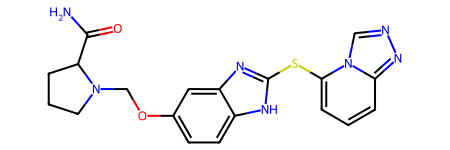

In [111]:
c = animal.C7273
display(c)
c.draw()